In [1]:
import os
import re
import math
from pathlib import Path

import numpy as np
import pandas as pd

In [2]:
# Add utils to this notebook's sys path
import sys; sys.path.insert(0, str(Path("../scripts/").resolve()))
import utils

## Constants

_Choose which dataset to plot results here!_

In [3]:
### ACS datasets:
DATASET = "ACSIncome"
# DATASET = "ACSEmployment"
# DATASET = "ACSTravelTime"
# DATASET = "ACSPublicCoverage"
# DATASET = "ACSMobility"

### Others:
# DATASET = "MEPS"

In [4]:
# Number of trials that we want to use
N_TRIALS = 50
SEED = 21

In [5]:
SHOW_DATA_TYPE = "test"               # Data to show in plots
# SHOW_DATA_TYPE = "validation"         # Use to plot validation results
SELECT_ON_DATA_TYPE = "validation"    # Data to use for model selection

PERFORMANCE_METRIC = "accuracy"
DISPARITY_METRIC = "equalized_odds_diff"

FIT_POSTPROC_ON_DATA_TYPE = "validation"   # will be updated to train if no validation data is available

## Load aggregated results

In [6]:
home_results_dir = Path("../results").resolve()

**Choose** which experimental results to use!

(should match the dataset chosen above; e.g., "MEPS" results cannot be used with "ACSIncome" dataset)

In [7]:
if "acs" in DATASET.lower():
    home_results_dir /= "ACS_T5.6-results_train=0.6_test=0.2_validation=0.2_max-groups=4_2023-09-06"
    # home_results_dir /= "ACS_T5.6-results_train=0.6_test=0.2_validation=0.2_max-groups=2_2023-09-06"
elif "meps" in DATASET.lower():
    home_results_dir /= "MEPS_T5.6-results_train_23380_test_15675_val_10020_3-groups_2023-09-08"
else:
    raise NotImplementedError(f"Dataset '{DATASET}' is not recognized.")

In [8]:
# Path to aggregated results file
task_df_path = home_results_dir / f"{DATASET}.{N_TRIALS}-trials.csv"

print(f"Loading experiments for {DATASET} dataset from '{task_df_path}'\n")
task_df = pd.read_csv(task_df_path, index_col=0, keep_default_na=False)

print(f"task_df.shape={task_df.shape}")
task_df.head(3)

Loading experiments for ACSIncome dataset from '/lustre/home/acruz/t5.6-supp-materials/results/ACS_T5.6-results_train=0.6_test=0.2_validation=0.2_max-groups=4_2023-09-06/ACSIncome.50-trials.csv'

task_df.shape=(1000, 767)


,original_test_accuracy,original_test_accuracy_diff,original_test_accuracy_diff_high-percentile,original_test_accuracy_diff_low-percentile,original_test_accuracy_diff_mean,original_test_accuracy_diff_stdev,original_test_accuracy_high-percentile,original_test_accuracy_low-percentile,original_test_accuracy_mean,original_test_accuracy_ratio,...,one_hot,base_model,meta_model,preprocessor_model,results_dir_path,results_json_path,model_pkl_path,unadjusted_pkl_path,expID,intervention
ACSIncome_base=lightgbm_meta=fairlearn-GS_equal-odds-constraint_preprocessor=None_one-hot=False_seed=26218916_hash=a34ed80b_2023.09.06-14.51,0.744541,0.274786,0.283394,0.262924,0.274291,0.004828,0.746105,0.743018,0.744561,0.666325,...,False,GBM,GS,None,/lustre/fast/fast/acruz/ACS_T5.6-results_train...,/lustre/fast/fast/acruz/ACS_T5.6-results_train...,/lustre/fast/fast/acruz/ACS_T5.6-results_train...,/lustre/fast/fast/acruz/ACS_T5.6-results_train...,"GBM, GS",GS
ACSIncome_base=skorch-NN_meta=None_preprocessor=aif360-LFR_one-hot=True_seed=748051385_hash=5b7d565c_2023.09.06-21.44,0.753566,0.083896,0.092331,0.075001,0.083683,0.004352,0.755075,0.752094,0.753549,0.897919,...,True,NN,None,LFR,/lustre/fast/fast/acruz/ACS_T5.6-results_train...,/lustre/fast/fast/acruz/ACS_T5.6-results_train...,/lustre/fast/fast/acruz/ACS_T5.6-results_train...,/lustre/fast/fast/acruz/ACS_T5.6-results_train...,"NN, LFR",LFR
ACSIncome_base=lightgbm_meta=None_preprocessor=aif360-LFR_one-hot=True_seed=523484801_hash=486fd14d_2023.09.06-19.11,0.707643,0.116491,0.124365,0.106229,0.116030,0.004601,0.709336,0.706151,0.707807,0.854481,...,True,GBM,None,LFR,/lustre/fast/fast/acruz/ACS_T5.6-results_train...,/lustre/fast/fast/acruz/ACS_T5.6-results_train...,/lustre/fast/fast/acruz/ACS_T5.6-results_train...,/lustre/fast/fast/acruz/ACS_T5.6-results_train...,"GBM, LFR",LFR


In [9]:
# Images directory
imgs_dir = Path("../imgs").resolve() / home_results_dir.name
imgs_dir.mkdir(exist_ok=True)

def save_fig(fig, fig_name: str, data_type: str = SHOW_DATA_TYPE):
    fig_name = f"{DATASET}.{fig_name}.{data_type}"
    fig.savefig(imgs_dir / f"{fig_name}.png", bbox_inches="tight")
    fig.savefig(imgs_dir / f"{fig_name}.pdf", bbox_inches="tight")

Maximum accuracy for a dummy constant classifier on each of these datasets:

In [10]:
max_const_acc = {
    
    # MEPS w/ 3 groups
    "MEPS": {
        "train": 0.8289136013686912,
        "test": 0.8323444976076555,
        "validation": 0.8261477045908183,
    },
    
    # ACS datasets w/ 4 groups
    "ACSIncome": {
        "train": 0.6276484057384071,
        "test": 0.6267948098880045,
        "validation": 0.6275487157120827
    },
    "ACSPublicCoverage": {
        "train": 0.705777716173447,
        "test": 0.7080615054796799,
        "validation": 0.7048998544597685
    },
    "ACSMobility": {
        "train": 0.7366843896876353,
        "test": 0.7369037614281713,
        "validation": 0.7358002054311933
    },
    "ACSEmployment": {
        "train": 0.5401004328892394,
        "test": 0.5415303116248027,
        "validation": 0.5397890715398488
    },
    "ACSTravelTime": {
        "train": 0.5622398192707292,
        "test": 0.5624768352647576,
        "validation": 0.5620214827548473
    },
    
    # ACS datasets w/ 2 groups
    "ACSIncome_2-groups": {
        "train": 0.6241850824111531,
        "test": 0.6235629798713427,
        "validation": 0.6248460953171474
    },
    "ACSPublicCoverage_2-groups": {
        "train": 0.705911281940385,
        "test": 0.7057204742123492,
        "validation": 0.7054798103987695
    },
    "ACSMobility_2-groups": {
        "train": 0.7357699820802996,
        "test": 0.7340249324383227,
        "validation": 0.7358240182878397
    },
    "ACSEmployment_2-groups": {
        "train": 0.5427848119370537,
        "test": 0.5421000690106448,
        "validation": 0.5429492932666349
    },
    "ACSTravelTime_2-groups": {
        "train": 0.5700311069059425,
        "test": 0.5691778590020926,
        "validation": 0.57097203519255
    },
}

DATASET_ID = DATASET + ("_2-groups" if "max-groups=2" in home_results_dir.name else "")
task_const_pred_acc = max_const_acc[DATASET_ID][SHOW_DATA_TYPE]

print(f"'{DATASET_ID}' max. const. acc. on {SHOW_DATA_TYPE} is {task_const_pred_acc:.2%}")

'ACSIncome' max. const. acc. on test is 62.68%


### Check number of experiments per algorithm type

In [11]:
# Identifier columns (some are still redundant, yes)
exp_id_cols = ["base_model", "intervention", "meta_model", "preprocessor_model", "one_hot"]

num_seeds = task_df.groupby(exp_id_cols)["seed"].nunique()

print(num_seeds.to_string())
print(f"Number of unique experiments: {num_seeds.sum()}")

base_model  intervention  meta_model  preprocessor_model  one_hot
GBM         CR            None        CR                  True       50
            EG            EG          None                False      50
            FairGBM       None        None                False      50
            GS            GS          None                False      50
            LFR           None        LFR                 True       50
            None          None        None                False      50
LR          CR            None        CR                  True       50
            EG            EG          None                True       50
            GS            GS          None                True       50
            LFR           None        LFR                 True       50
            None          None        None                True       50
NN          CR            None        CR                  True       50
            EG            EG          None                True       5

---
# Analyze results

In [12]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
sns.set(style="whitegrid", palette="colorblind", rc={"grid.linestyle": "--"})

---
Plot parameters:
- order of labels (algorithm type and intervention type);
- color and marker style for each label;
- legend kwargs, scatterplot kwargs, figure kwargs, ...

In [13]:
base_model_labels_sort = task_df["base_model"].unique().tolist()
base_model_labels_sort = sorted(base_model_labels_sort)

base_model_to_color_map = dict(zip(base_model_labels_sort, sns.color_palette()))
palette = [base_model_to_color_map[bm] for bm in base_model_labels_sort]

print(f"Order of base model labels: {base_model_labels_sort}")

Order of base model labels: ['GBM', 'LR', 'NN', 'RF']


In [14]:
task_df["intervention"].unique()

array(['GS', 'LFR', 'CR', 'EG', 'None', 'FairGBM'], dtype=object)

In [15]:
intervention_labels_sort = sorted(task_df["intervention"].unique().tolist())

# Set "None" (no intervention) in the beginning and "FairGBM" at the end (as it only applies to GBM)
intervention_labels_sort.remove("None")
intervention_labels_sort.remove("FairGBM")
intervention_labels_sort = ["None"] + intervention_labels_sort + ["FairGBM"]

intervention_labels_markers = ["o", (4, 0, 0), "P", "X", (5, 1, 0), "^"]
intervention_to_marker_map = dict(zip(intervention_labels_sort, intervention_labels_markers))

print(intervention_labels_sort)

['None', 'CR', 'EG', 'GS', 'LFR', 'FairGBM']


In [16]:
def compute_expID_sort_key(expID: str) -> int:

    # Sort by base_model first
    base_key = [
        idx 
        for idx, bmodel in enumerate(base_model_labels_sort) 
        if bmodel in expID
    ][0]
    
    # Then sort by intervention
    interv_key = [
        idx
        for idx, interv in enumerate(intervention_labels_sort)
        if interv in expID
    ]

    # Put unconstrained methods first
    interv_key = interv_key[0] if interv_key else -1

    return base_key * 100 + interv_key

exp_id_labels_sort = sorted(
    task_df["expID"].unique().tolist(),
    key=compute_expID_sort_key,
)

print(exp_id_labels_sort)

['GBM', 'GBM, CR', 'GBM, EG', 'GBM, GS', 'GBM, LFR', 'FairGBM', 'LR', 'LR, CR', 'LR, EG', 'LR, GS', 'LR, LFR', 'NN', 'NN, CR', 'NN, EG', 'NN, LFR', 'RF', 'RF, CR', 'RF, EG', 'RF, GS', 'RF, LFR']


In [17]:
# Some global plot settings
plt.rc(
    "figure",
    figsize=(10, 3),
    dpi=200,
)

ax_kwargs = dict(
    title=f"{DATASET} ({SHOW_DATA_TYPE})",
    xlabel=PERFORMANCE_METRIC,
    ylabel="constraint violation",
#     ylabel="fairness violation",
#     ylabel="equal odds diff.",
)

plot_ax_lim_per_task = {
    "MEPS": dict(
        xlim=(task_const_pred_acc - 1.5e-3, 0.866),
        ylim=(-0.005, 0.2),
    ),

    "ACSIncome": dict(
        xlim=(task_const_pred_acc - 1e-2, 0.832),
        ylim=(-0.02, 0.5),
    ),

    "ACSEmployment": dict(
        xlim=(task_const_pred_acc - 1.5e-2, 0.845),
        ylim=(-0.01, 0.2),
    ),

    "ACSMobility": dict(
        xlim=(task_const_pred_acc - 2.5e-3, 0.7725),
        ylim=(-0.01, 0.2),
    ),

    "ACSPublicCoverage": dict(
        xlim=(task_const_pred_acc - 5e-3, 0.8125),
        ylim=(-0.02, 0.6),
    ),

    "ACSTravelTime": dict(
        xlim=(task_const_pred_acc - 1e-2, 0.72),
        ylim=(-0.02, 0.35),
    ),
    
    # ACS datasets w/ binary protected groups
    "ACSIncome_2-groups": dict(
        xlim=(task_const_pred_acc - 1e-2, 0.828),
        ylim=(-0.02, 0.35),
    ),

    "ACSTravelTime_2-groups": dict(
        xlim=(task_const_pred_acc - 1e-2, 0.724),
        ylim=(-0.01, 0.2),
    ),

    "ACSMobility_2-groups": dict(
        xlim=(task_const_pred_acc - 2.5e-3, 0.771),
        ylim=(-0.002, 0.1),
    ),

    "ACSEmployment_2-groups": dict(
        xlim=(task_const_pred_acc - 1.5e-2, 0.845),
        ylim=(-0.002, 0.1),
    ),

    "ACSPublicCoverage_2-groups": dict(
        xlim=(task_const_pred_acc - 5e-3, 0.816),
        ylim=(-0.01, 0.2),
    ),
}

ax_kwargs.update(plot_ax_lim_per_task.get(DATASET_ID, plot_ax_lim_per_task[DATASET]))

In [18]:
# Default kwargs to be used by most plots
scatterplot_kwargs = dict(
    x=PERFORMANCE_METRIC,
    y=DISPARITY_METRIC,
    hue="base model",
    style="fairness method",
#     hue="base_model",
#     style="intervention",

    hue_order=base_model_labels_sort,
    style_order=intervention_labels_sort,

    palette=palette,
    markers=intervention_labels_markers,
#     hue="expID",
#     style="expID",
)

legend_kwargs = dict(
    bbox_to_anchor=(1.03, 1),
    loc="upper left",
    borderaxespad=0,
)

---

In [19]:
def get_results(
        model_type: str,
        data_type: str = "test",
    ) -> pd.DataFrame:
    assert model_type in ("original", "unadjusted")
    assert data_type in ("test", "validation", "validation-solution")

    col_prefix = f"{model_type}_{data_type}"
#     perf_col = f"{col_prefix}_{PERFORMANCE_METRIC}"
#     disp_col = f"{col_prefix}_{DISPARITY_METRIC}"
    perf_col = f"{col_prefix}_{PERFORMANCE_METRIC}_mean"
    disp_col = f"{col_prefix}_{DISPARITY_METRIC}_mean"

    return task_df[
        exp_id_cols + ["expID", perf_col, disp_col]
    ].rename(
        columns={
            perf_col: PERFORMANCE_METRIC,
            disp_col: DISPARITY_METRIC,
            "base_model": "base model",
            "intervention": "fairness method",
#             "intervention": "fairness interv.",
        }
    )

## Results for original models (not postprocessed)

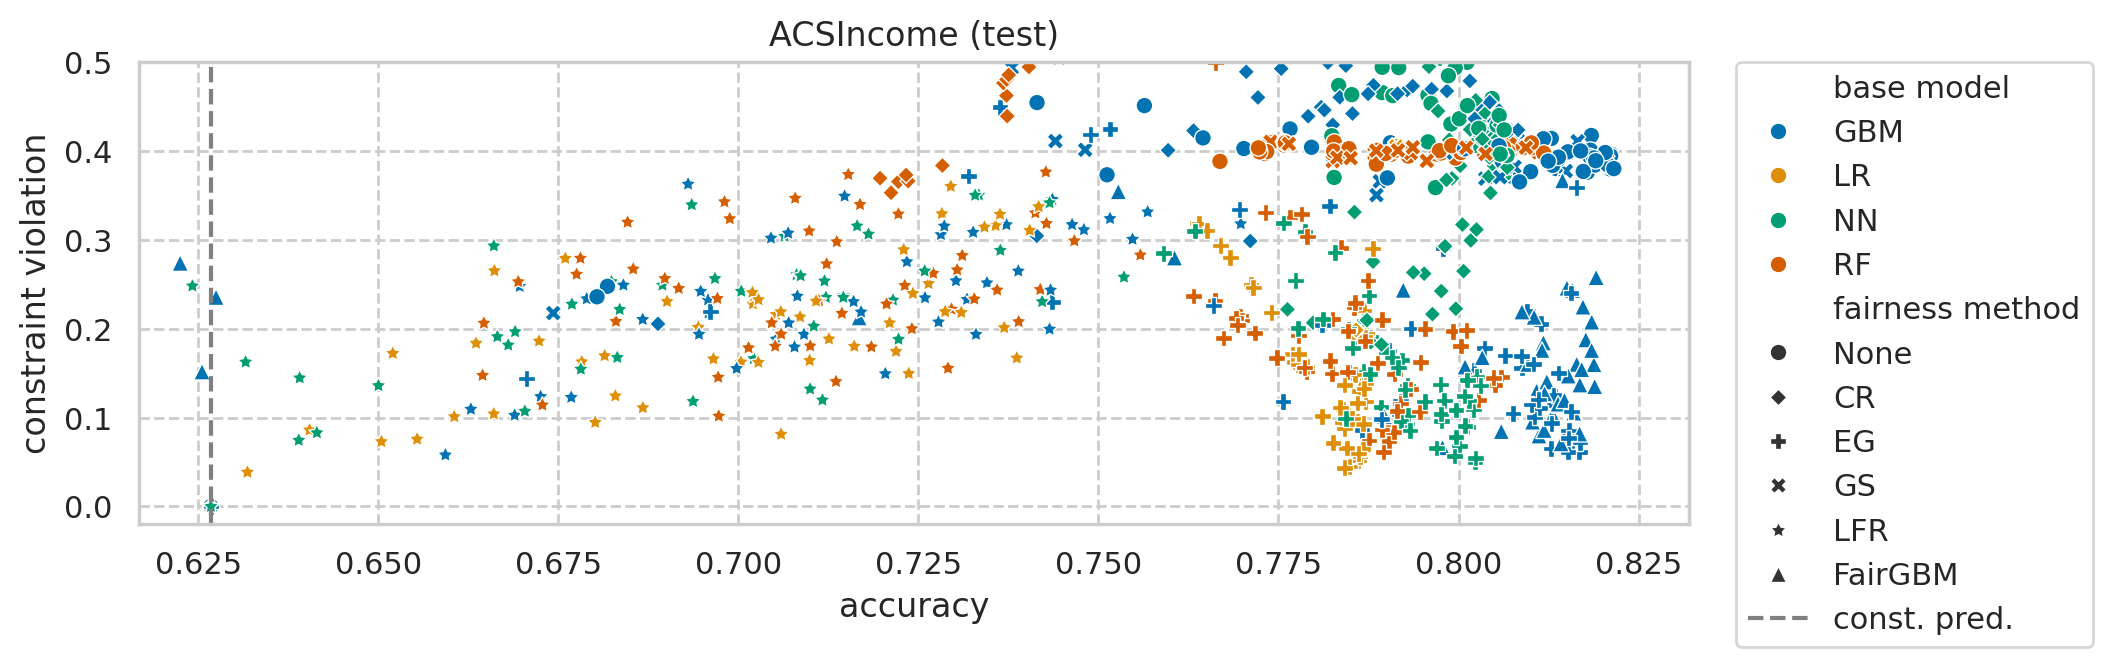

In [20]:
sns.scatterplot(
    data=get_results("original", SHOW_DATA_TYPE),
    **scatterplot_kwargs,
)

# Vertical line with minimum "useful" accuracy on this data
plt.axvline(
    x=task_const_pred_acc,
    ls="--",
    label="const. pred.",
    color="grey",
)

plt.legend(**legend_kwargs)
plt.gca().set(**ax_kwargs)

save_fig(fig=plt.gcf(), fig_name="all-original-models")
plt.show()

#### GBM-only results

In [21]:
gbm_exp_id_labels_sort = [label for label in exp_id_labels_sort if "GBM" in label]
gbm_exp_id_to_color_map = dict(zip(gbm_exp_id_labels_sort, sns.color_palette(n_colors=len(gbm_exp_id_labels_sort))))

gbm_plot_kwargs = (
    scatterplot_kwargs |
    dict(
        hue="expID",
        style="expID",
        hue_order=gbm_exp_id_labels_sort,
        style_order=gbm_exp_id_labels_sort,
        markers=intervention_labels_markers,
        palette=None,
    )
)

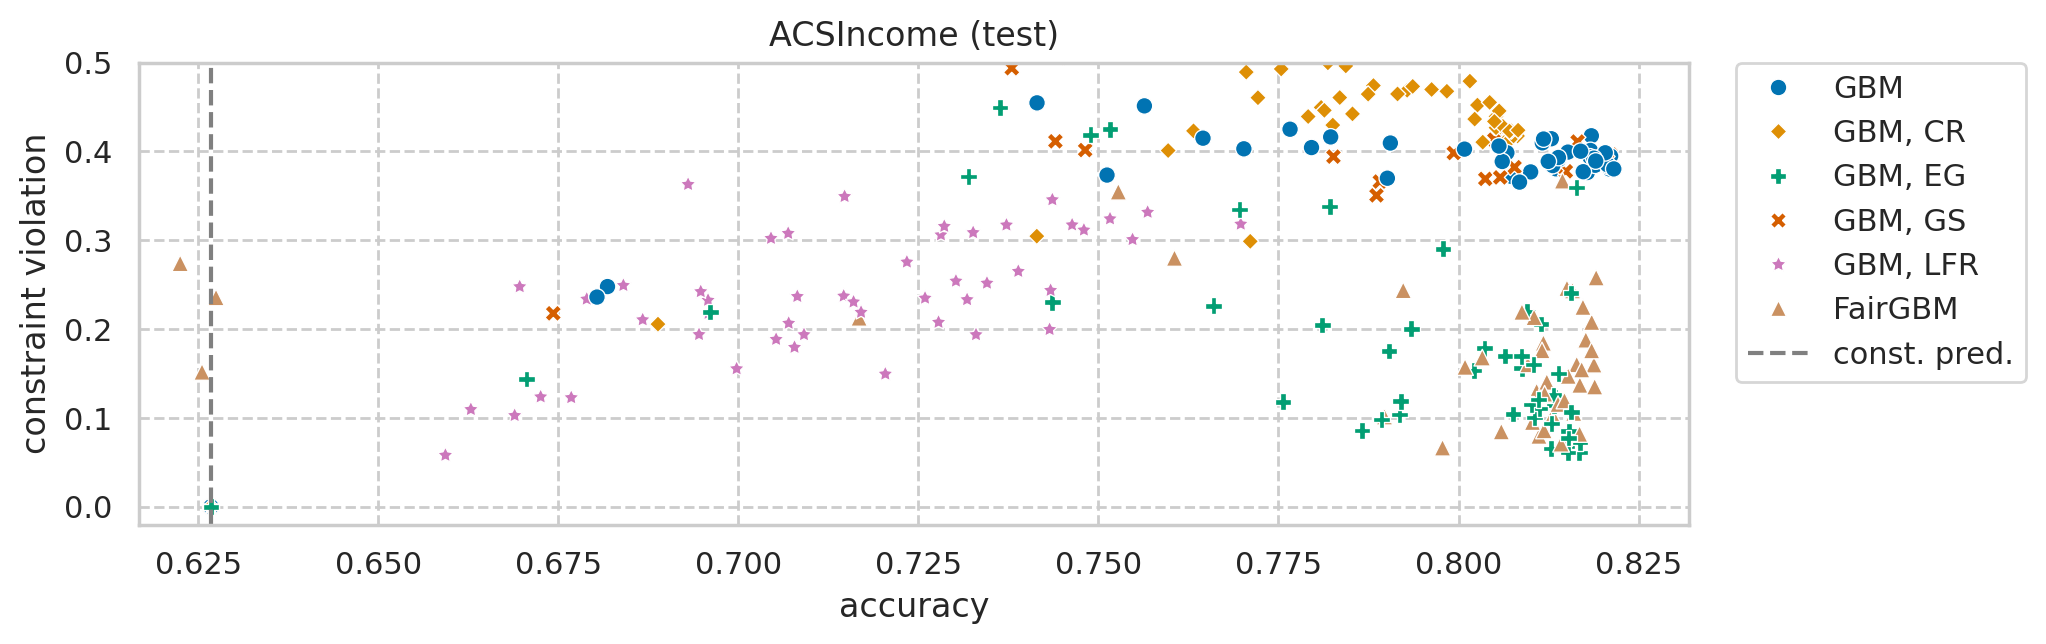

In [22]:
plot_df = get_results("original", SHOW_DATA_TYPE)
plot_df = plot_df[plot_df["base model"] == "GBM"]

sns.scatterplot(
    data=plot_df,
    **gbm_plot_kwargs,
)

# Vertical line with minimum "useful" accuracy on this data
plt.axvline(
    x=task_const_pred_acc,
    ls="--",
    label="const. pred.",
    color="grey",
)

plt.legend(**legend_kwargs)
plt.gca().set(**ax_kwargs)

save_fig(fig=plt.gcf(), fig_name="gbm-original-models")
plt.show()

## Results for unadjusted models (the actual results we care about)

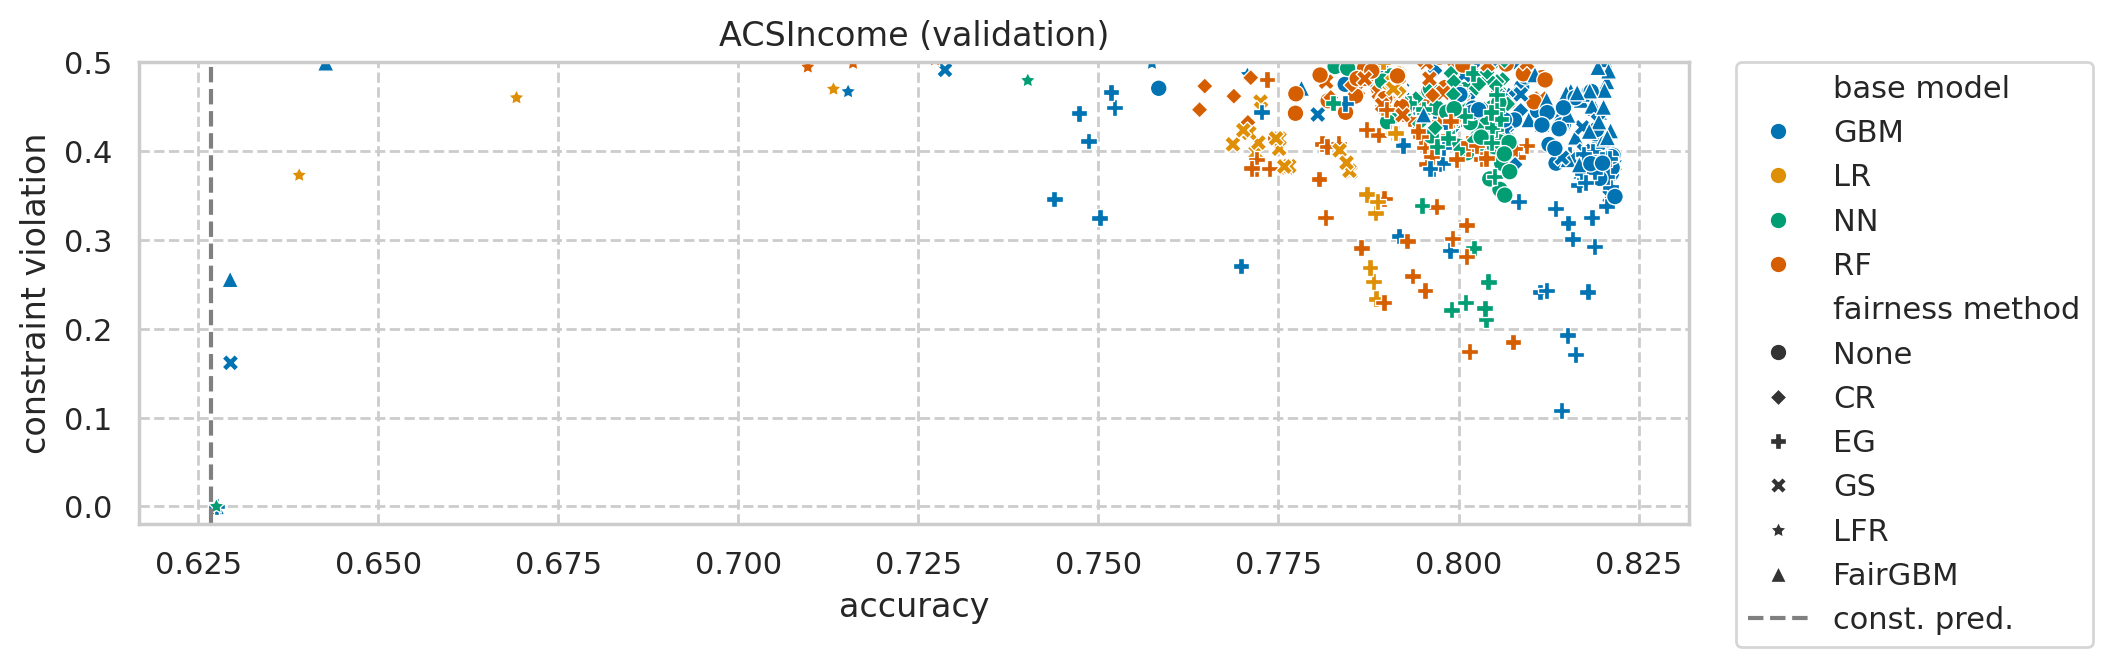

In [23]:
sns.scatterplot(
    data=get_results("unadjusted", "validation"),
    **scatterplot_kwargs,
)

# Vertical line with minimum "useful" accuracy on this data
plt.axvline(
    x=task_const_pred_acc,
    ls="--",
    label="const. pred.",
    color="grey",
)

plt.legend(**legend_kwargs)
plt.gca().set(**ax_kwargs)

plt.title(f"{DATASET} (validation)")

save_fig(fig=plt.gcf(), fig_name="all-unadjusted-models", data_type="validation")
plt.show()

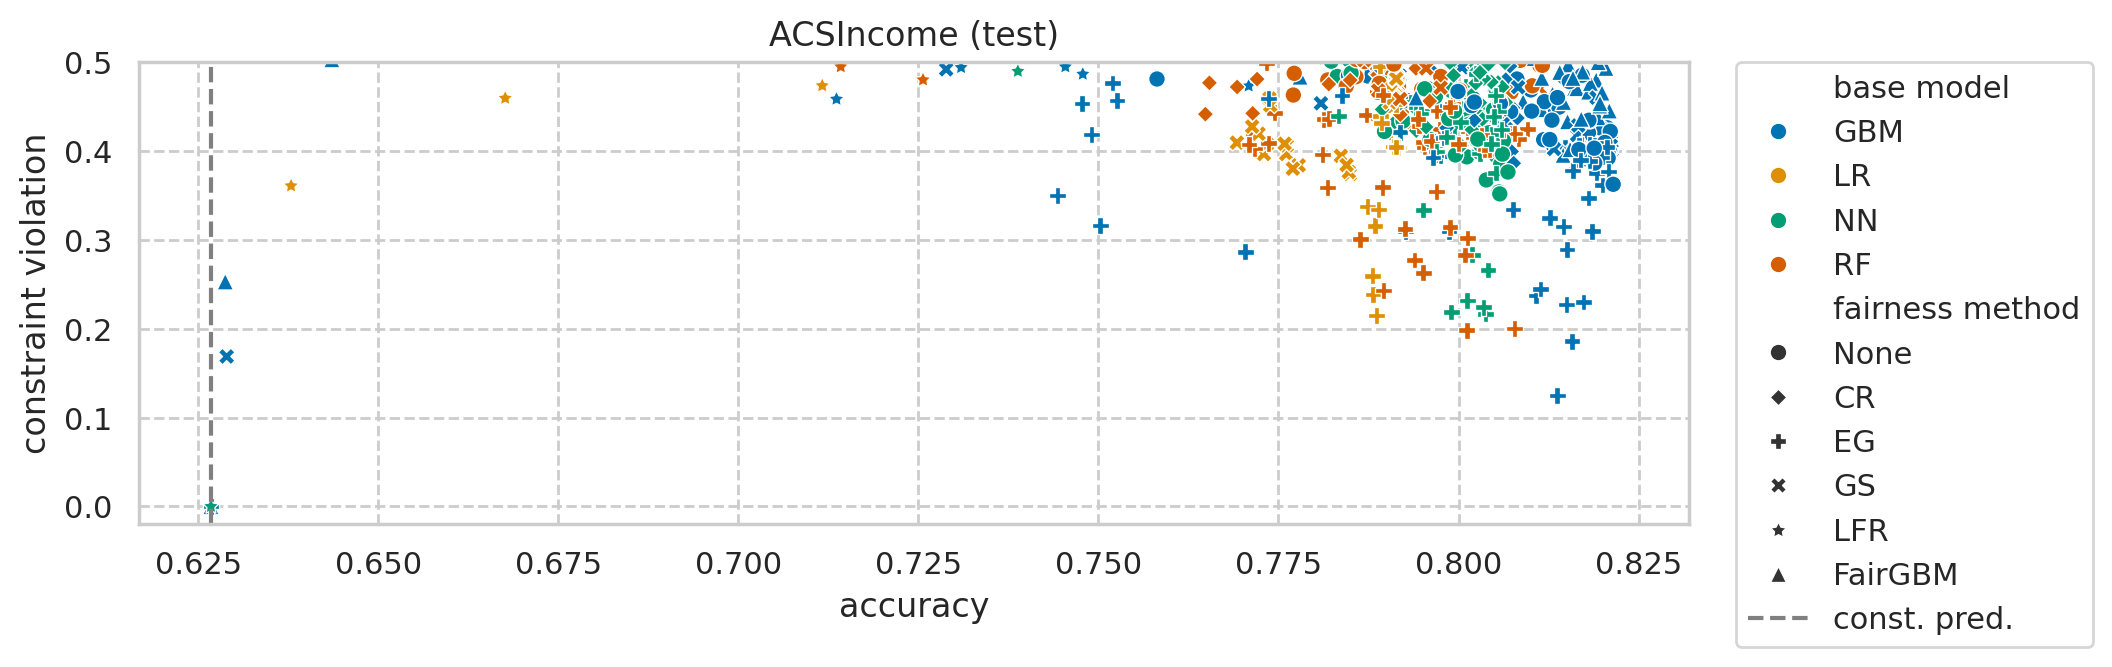

In [24]:
sns.scatterplot(
    data=get_results("unadjusted", SHOW_DATA_TYPE),
    **scatterplot_kwargs,
)

# Vertical line with minimum "useful" accuracy on this data
plt.axvline(
    x=task_const_pred_acc,
    ls="--",
    label="const. pred.",
    color="grey",
)

plt.legend(**legend_kwargs)
plt.gca().set(**ax_kwargs)

save_fig(fig=plt.gcf(), fig_name="all-unadjusted-models")
plt.show()

#### GBM-only results

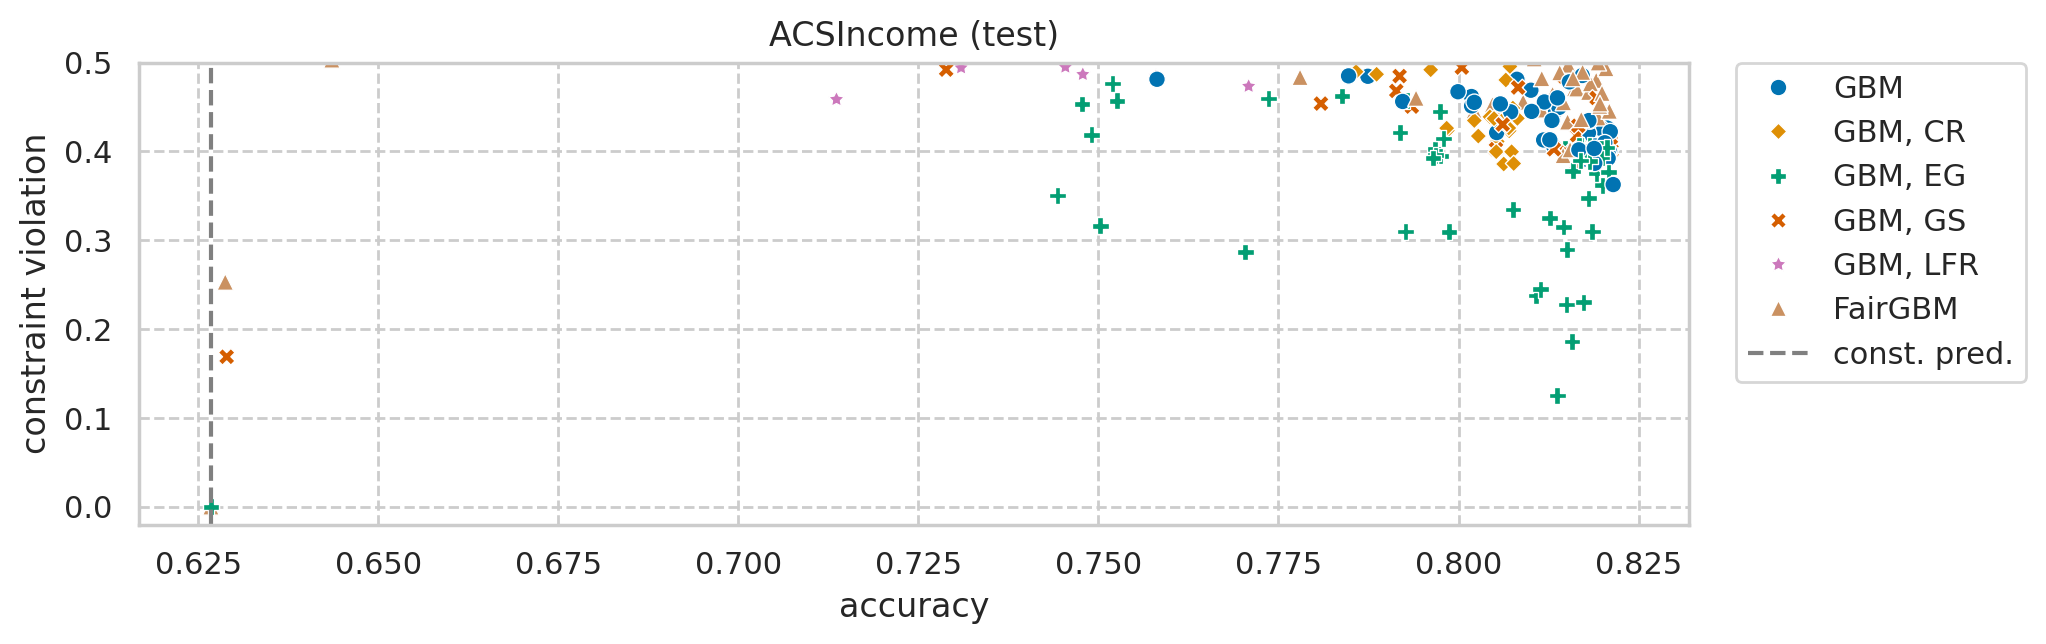

In [25]:
plot_df = get_results("unadjusted", SHOW_DATA_TYPE)
plot_df = plot_df[plot_df["base model"] == "GBM"]

sns.scatterplot(
    data=plot_df,
    **gbm_plot_kwargs,
)

# Vertical line with minimum "useful" accuracy on this data
plt.axvline(
    x=task_const_pred_acc,
    ls="--",
    label="const. pred.",
    color="grey",
)

plt.legend(**legend_kwargs)
plt.gca().set(**ax_kwargs)

save_fig(fig=plt.gcf(), fig_name="gbm-unadjusted-models")
plt.show()

---
### Plot original and unadjusted models in two scatterplots side-by-side (shared y axis)

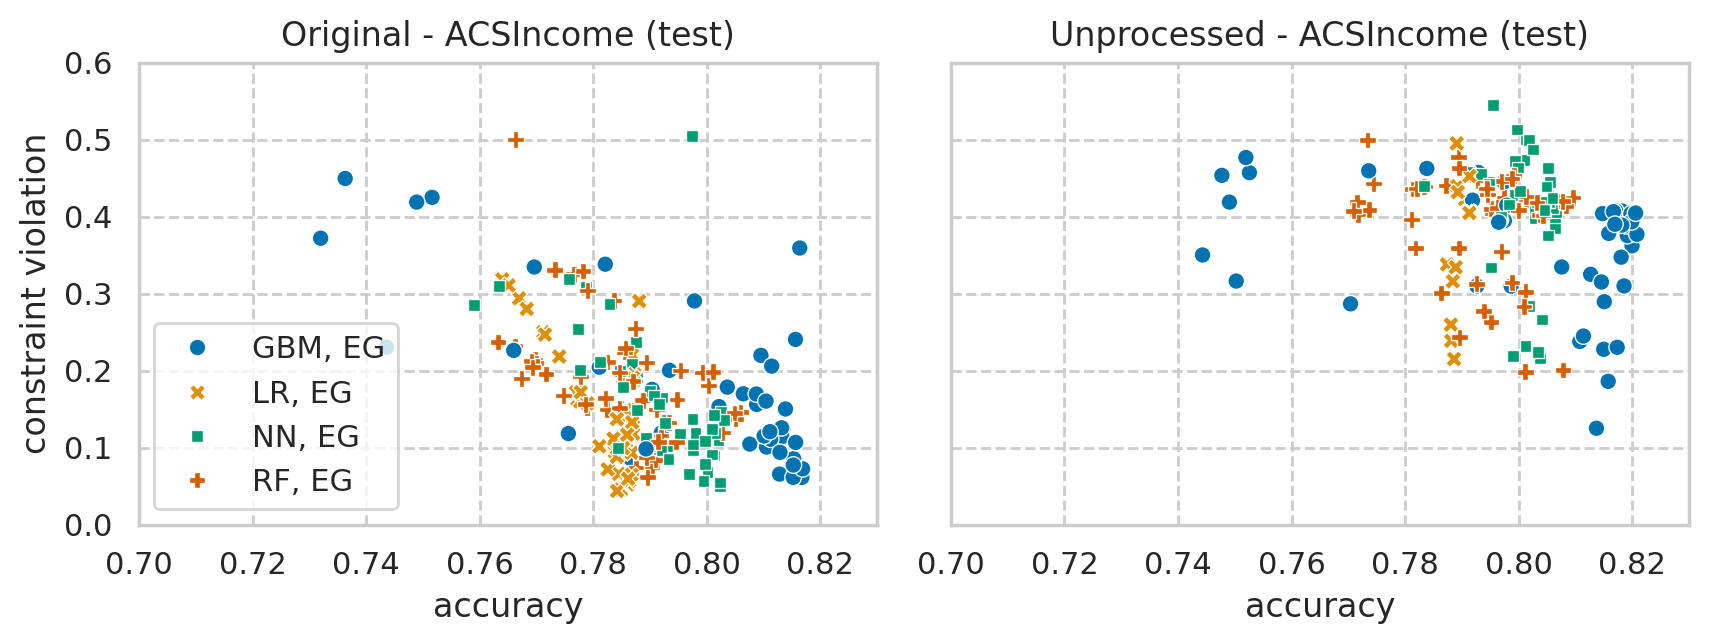

In [26]:
USE_INTERVENTION = "EG"

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, gridspec_kw=dict(wspace=0.1))


# Hue and style legend order
eg_hue_label_order = [expID for expID in exp_id_labels_sort if expID.endswith(USE_INTERVENTION)]
eg_plot_kwargs = dict(
    x=PERFORMANCE_METRIC,
    y=DISPARITY_METRIC,
    hue="expID",
    style = "expID",
    hue_order=eg_hue_label_order,
    style_order=eg_hue_label_order,
)

eg_ax_kwargs = ax_kwargs | dict(
    xlim=(task_const_pred_acc, ax_kwargs["xlim"][1]),
)
eg_ax_kwargs.pop("title")

if DATASET == "ACSIncome" and USE_INTERVENTION == "EG":
    eg_ax_kwargs["xlim"] = (0.7, 0.83)
    eg_ax_kwargs["ylim"] = (0, 0.6)

elif DATASET == "ACSEmployment":
    eg_ax_kwargs["xlim"] = (0.8, 0.84)
    eg_ax_kwargs["ylim"] = (0, 0.2)


# Plot original models on left plot
og_plot_df = get_results("original", SHOW_DATA_TYPE)
og_plot_df = og_plot_df[og_plot_df["fairness method"] == USE_INTERVENTION]

sns.scatterplot(
    data=og_plot_df,
    ax=ax1,
    **eg_plot_kwargs,
)

ax1.set(
    **eg_ax_kwargs,
    title=f"Original - {DATASET} ({SHOW_DATA_TYPE})",
)
ax1.legend(title=None)


# Plot unprocessed models on right plot
un_plot_df = get_results("unadjusted", SHOW_DATA_TYPE)
un_plot_df = un_plot_df[un_plot_df["fairness method"] == USE_INTERVENTION]

sns.scatterplot(
    data=un_plot_df,
    ax=ax2,
    **eg_plot_kwargs,
)
ax2.set(
    **eg_ax_kwargs,
    title=f"Unprocessed - {DATASET} ({SHOW_DATA_TYPE})",
)

ax2.get_legend().remove()


save_fig(fig=plt.gcf(), fig_name=f"{USE_INTERVENTION}-original-vs-unprocessed")

plt.show()

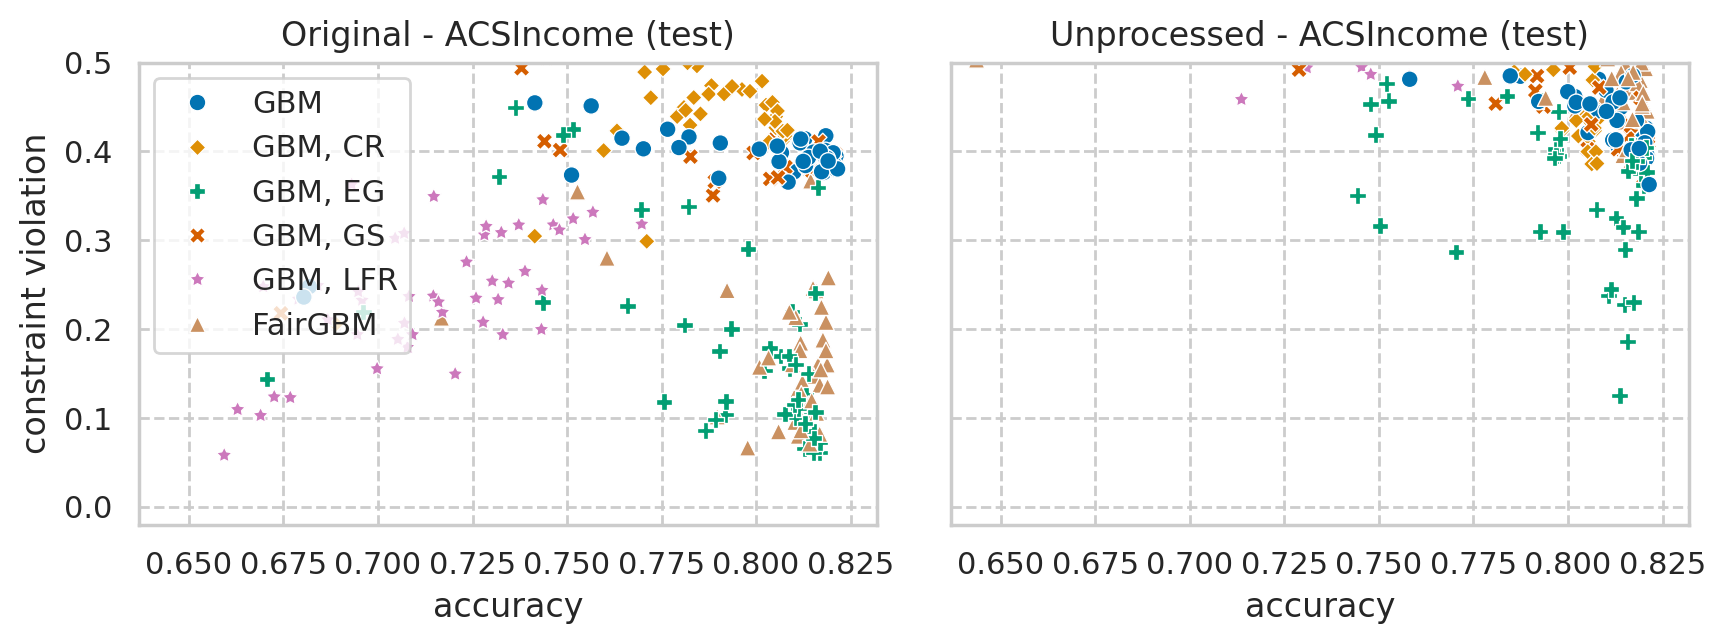

In [27]:
USE_BASE_MODEL = "GBM"

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, gridspec_kw=dict(wspace=0.1))

# Order of expIDs
expIDs_hue_label_order = [expID for expID in exp_id_labels_sort if USE_BASE_MODEL in expID]
bm_plot_kwargs = dict(
    x=PERFORMANCE_METRIC,
    y=DISPARITY_METRIC,
    hue="expID",
    style = "expID",
    hue_order=expIDs_hue_label_order,
    style_order=expIDs_hue_label_order,
)

# Plot original models on left plots
og_plot_df = get_results("original", SHOW_DATA_TYPE)
og_plot_df = og_plot_df[og_plot_df["base model"] == USE_BASE_MODEL]

# Set markers and palette
bm_plot_kwargs["markers"] = [
    intervention_to_marker_map[fairness_method]
    for fairness_method in (
        og_plot_df.sort_values(
            "expID",
            key=lambda expID_series: [expIDs_hue_label_order.index(expID) for expID in expID_series]
        )["fairness method"].unique()
    )
]

sns.scatterplot(
    data=og_plot_df,
    **bm_plot_kwargs,
    ax=ax1,
)

ax1.set(**(ax_kwargs | dict(
    xlim=(task_const_pred_acc + 1e-2, ax_kwargs["xlim"][1]),
    title=f"Original - {DATASET} ({SHOW_DATA_TYPE})",
#     title=f"Original {USE_BASE_MODEL}",
)))
ax1.legend(title=None, loc="upper left")


un_plot_df = get_results("unadjusted", SHOW_DATA_TYPE)
un_plot_df = un_plot_df[un_plot_df["base model"] == USE_BASE_MODEL]

sns.scatterplot(
    data=un_plot_df,
    **bm_plot_kwargs,
    ax=ax2,
)

ax2.set(**(ax_kwargs | dict(
    xlim=(task_const_pred_acc + 1e-2, ax_kwargs["xlim"][1]),
    title=f"Unprocessed - {DATASET} ({SHOW_DATA_TYPE})",
#     title=f"Unprocessed {USE_BASE_MODEL}",
)))
ax2.get_legend().remove()



save_fig(fig=plt.gcf(), fig_name=f"{USE_BASE_MODEL.lower()}-original-vs-unprocessed")

plt.show()

---
_**Helper functions for adjustment/postprocessing curve**_

In [28]:
from utils import MODEL_PREDICTIONS_VALIDATION
from utils.postprocessing import load_or_compute_adjustment_curve
from utils.models import compute_model_predictions

def compute_adjustment_curve_helper(model, exp_dir, all_data, **kwargs):
    X_val, y_val, s_val = all_data["validation"]
    predictions_save_path = exp_dir / MODEL_PREDICTIONS_VALIDATION

    y_scores_val = compute_model_predictions(
        model, X_val, s_val,
        predictions_save_path=predictions_save_path,
    )

    global FIT_POSTPROC_ON_DATA_TYPE
    FIT_POSTPROC_ON_DATA_TYPE = "validation" if "validation" in all_data else "train"

    adjustment_results_df = load_or_compute_adjustment_curve(
        model=model,
        exp_dir=exp_dir,
        fit_data=all_data.get(FIT_POSTPROC_ON_DATA_TYPE),
        y_fit_pred_scores=y_scores_val,
        eval_data={
            "validation": all_data["validation"],
            "test": all_data["test"],
        },
        n_jobs=max(1, os.cpu_count() - 1),
        fairness_constraint="equalized_odds",
        tolerance_ticks=np.hstack((
            np.arange(0.0, 0.5, 1e-2),
            np.arange(0.5, 1.0, 1e-1),
        )),
        **kwargs,
    )

    return adjustment_results_df

In [29]:
from utils.notebook import load_experiment_data, load_or_refit_experiment_model
from error_parity.pareto_curve import compute_inner_and_outer_adjustment_ci, get_envelope_of_postprocessing_frontier

def get_adjustment_curve_from_model_row(model_row, use_precomputed_curve=True):
    """Helper to load or compute adjustment curve for the given model row in the results DF.
    """

    # Load (or compute) adjustment curve
    # > Load:
    adj_curve_path = (
        home_results_dir
        / "postprocessing-adjustment-curves"
        / model_row.name
        / "model-adjustment-curve.bootstrap.csv"
    )

    assert adj_curve_path.exists(), f"Couldn't find pre-computed results for '{model_row.name}' at '{adj_curve_path}'"
    adjustment_results_df = pd.read_csv(adj_curve_path, index_col=0)

    """
    # Else, compute and save to disk
    if not adj_curve_path.exists():
        print("Couldn't find pre-computed postprocessing results, will need to re-compute them...")

        # > Compute
        adjustment_results_df = compute_adjustment_curve_helper(
            model=model,
            exp_dir=exp_dir,
            all_data=all_data,
            bootstrap=True,
            load_if_available=use_precomputed_curve,
        )

        # > Save to disk
        adjustment_results_df.to_csv(adj_curve_path, index=True)
    """

    # Get adjustment frontier
    adjustment_frontier = get_envelope_of_postprocessing_frontier(
        adjustment_results_df,
        constant_clf_perf=task_const_pred_acc,
    )

    # Get inner and outer conf. interv. for adjustment frontier
    (
        adjustment_frontier_xticks,
        interior_frontier_yticks,
        outer_frontier_yticks,
    ) = compute_inner_and_outer_adjustment_ci(
            adjustment_results_df,
            perf_metric=PERFORMANCE_METRIC,
            disp_metric=DISPARITY_METRIC,
            data_type=SHOW_DATA_TYPE,
            constant_clf_perf=task_const_pred_acc,
        )

    return {
        "adjustment_results_df": adjustment_results_df,
        "adjustment_frontier": adjustment_frontier,
        "adjustment_frontier_xticks": adjustment_frontier_xticks,
        "interior_frontier_yticks": interior_frontier_yticks,
        "outer_frontier_yticks": outer_frontier_yticks,
    }

_**END OF: Helper functions for adjustment/postprocessing curve**_

---

---
# Main plot (w/ postprocessing curve)

#### (GBM-only) Select best-performing unadjusted model and plot adjustment frontier
The adjustment line should be outside all other models.

---

In [30]:
bottom_legend_kwargs = dict(
    bbox_to_anchor=(0.5, -0.21),
    loc="upper center",
    ncols=3,
    columnspacing=4,
)

In [31]:
all_plots_df = get_results("original", SHOW_DATA_TYPE)

# TODO: fix this plot for each algorithm type
# plus, add shaded area for postprocessing!

# for bm in all_plots_df["base model"].unique():

# Define base model
BASE_MODEL = "GBM" # TODO: plot for other base models

# DF with data for this plot
plot_df = all_plots_df[all_plots_df["base model"] == BASE_MODEL]
plot_df = plot_df[plot_df[PERFORMANCE_METRIC] >= task_const_pred_acc + 1e-3]    # discard worse-than-dummy predictors

# Select best model among these base models
results_for_model_selection = task_df.loc[plot_df.index]    # only `bm` results
model_row = results_for_model_selection.sort_values(
#         f"original_{SELECT_ON_DATA_TYPE}_squared_loss",  # Select model with highest unadjusted performance
#         ascending=True,
        f"unadjusted_{SELECT_ON_DATA_TYPE}_{PERFORMANCE_METRIC}",  # Select model with highest unadjusted performance
        ascending=False,
).iloc[0]
print(f"Best {BASE_MODEL} model: {model_row['expID']}")

Best GBM model: GBM


In [32]:
adjustment_vars = get_adjustment_curve_from_model_row(model_row)
globals().update(adjustment_vars)

In [33]:
# Best model used for adjustment curve (plot unadjusted point?)
best_model_acc, best_model_disp = adjustment_frontier[-1]
# best_model_acc = model_row[f"unadjusted_{SHOW_DATA_TYPE}_{PERFORMANCE_METRIC}"]
# best_model_disp = model_row[f"unadjusted_{SHOW_DATA_TYPE}_{DISPARITY_METRIC}"]

In [34]:
m_star_xytext_custom = {
    "ACSMobility": (best_model_acc+4e-4, best_model_disp+2e-3),
    "ACSEmployment": (best_model_acc+1.5e-3, best_model_disp+7e-3),
    "ACSTravelTime": (best_model_acc+1e-3, best_model_disp+1e-2),
    "ACSPublicCoverage": (best_model_acc+7e-4, best_model_disp+1.8e-2),
    "ACSEmployment_2-groups": (best_model_acc+7e-4, best_model_disp+1.5e-3),
    "ACSPublicCoverage_2-groups": (best_model_acc+5e-4, best_model_disp+1e-2),
}

m_star_xytext = m_star_xytext_custom.get(DATASET_ID, (best_model_acc+1.5e-3, best_model_disp+1.8e-2))

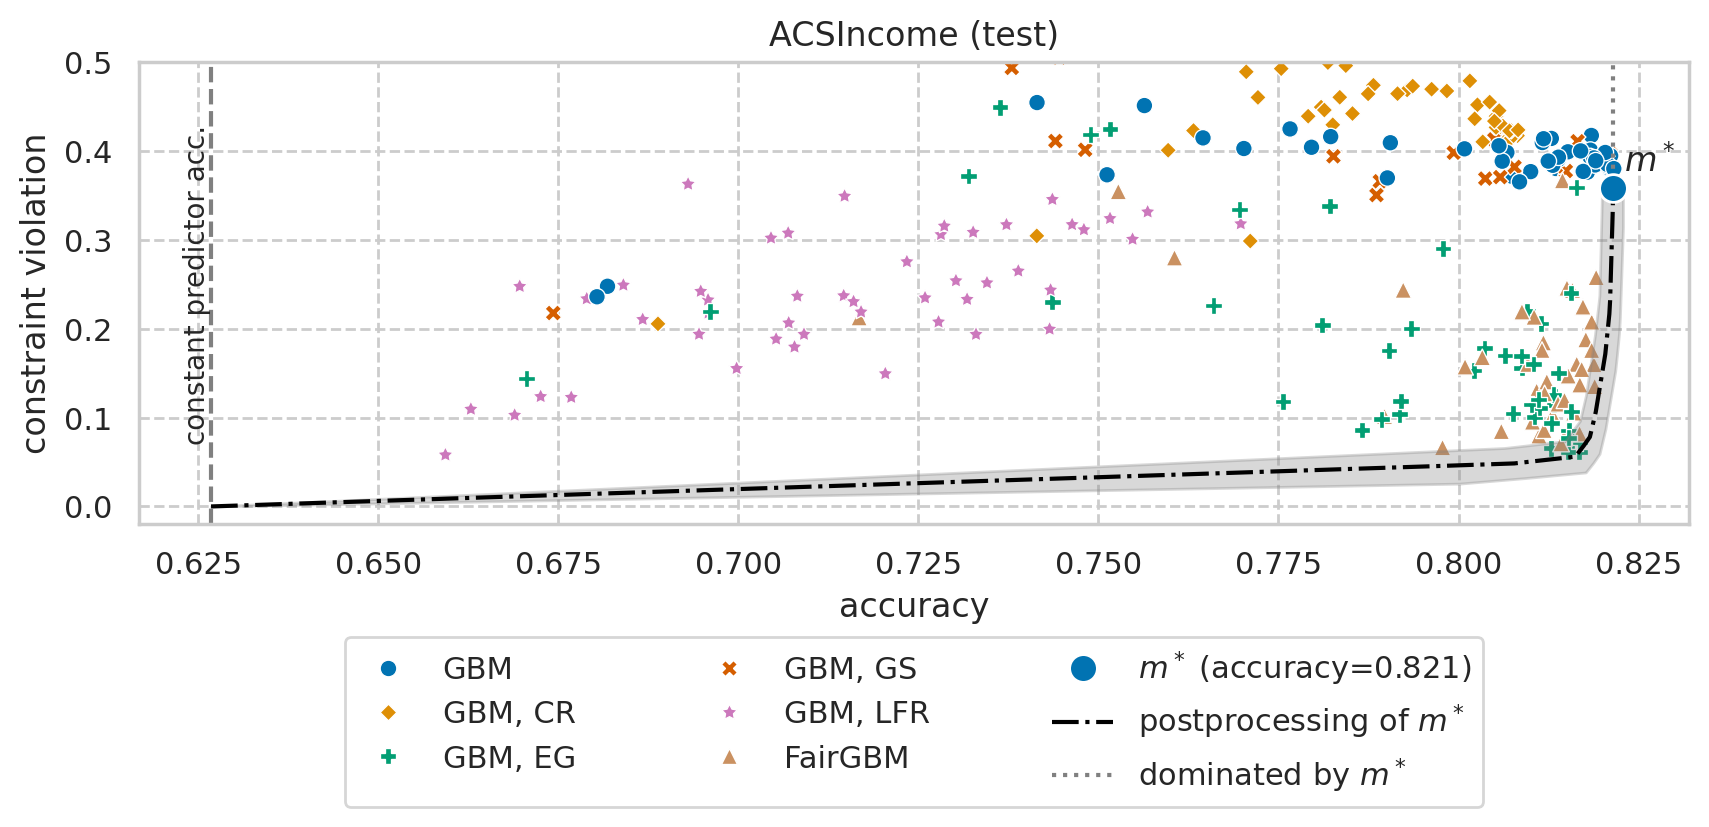

In [35]:
# Plot all points
sns.scatterplot(
    data=plot_df,
    **gbm_plot_kwargs,
#         **scatterplot_kwargs,
)

# Plot model used for adjustment curve
plt.plot(
    best_model_acc, best_model_disp,
    color=gbm_exp_id_to_color_map[model_row.expID],
    marker=intervention_to_marker_map[model_row.intervention],
    ms=10, lw=0,
    markeredgecolor="white",
    label=f"$m^*$ (accuracy={best_model_acc:.3f})",
    zorder=10,
)

# Annotate best model with "m^*"
plt.gca().annotate(
    r"$m^*$",
    xy=(best_model_acc, best_model_disp),
    xytext=m_star_xytext,
    zorder=10,
)

# Plot adjustment curve
sns.lineplot(
    x=adjustment_frontier[:, 0],
    y=adjustment_frontier[:, 1],
    label=r"postprocessing of $m^*$",
    linestyle="-.",
    color="black",
)

# Draw upper right portion of the line (dominated but not feasible)
upper_right_frontier = np.array([
    adjustment_frontier[-1],
    (adjustment_frontier[-1, 0] - 1e-6, 1.0),
])

sns.lineplot(
    x=upper_right_frontier[:, 0],
    y=upper_right_frontier[:, 1],
    linestyle=":",
    label=r"dominated by $m^*$",
    color="grey",
)

#### #### #### SHADED AREA - CONFIDENCE INTERVALS
ax = plt.gca()

ax.fill_between(
    x=adjustment_frontier_xticks,
    y1=interior_frontier_yticks,
    y2=outer_frontier_yticks,
    interpolate=True,
    color="grey",
    alpha=0.3,
#     label=r"$95\%$ confidence interv.",
)

#### #### #### SHADED AREA - CONFIDENCE INTERVALS


# Vertical line with minimum "useful" accuracy on this data
plt.axvline(
    x=task_const_pred_acc,
    ls="--",
#     label="constant predictor",
    color="grey",
)
plt.gca().annotate(
    "constant predictor acc.",
    xy=(task_const_pred_acc, ax_kwargs["ylim"][1] / 2),
    zorder=10,
    rotation=90,
    horizontalalignment="right",
    verticalalignment="center",
    fontsize="small",
    
)

# plt.legend(**legend_kwargs)
plt.legend(**bottom_legend_kwargs)

plt.gca().set(**ax_kwargs)

save_fig(fig=plt.gcf(), fig_name=f"{BASE_MODEL.lower()}-only.with-adjustment-curve")
plt.show()

---

## Select best overall model and plot adjustment frontier (same plot but now with all algorithms)

In [36]:
# Get best model
best_overall_model_row = task_df.sort_values(
#         f"original_{SELECT_ON_DATA_TYPE}_squared_loss",  # Select model with highest unadjusted performance
#         ascending=True,
        f"unadjusted_{SELECT_ON_DATA_TYPE}_{PERFORMANCE_METRIC}",  # Select model with highest unadjusted performance
        ascending=False,
    ).iloc[0]

print(f"Best overall model: {best_overall_model_row['expID']}")

if best_overall_model_row.name != model_row.name:
    model_row = best_overall_model_row

    # It's a different model, need to load it into memory...
    print("Best model is different, loading model into memory...")

    model_row_vars = get_adjustment_curve_from_model_row(model_row)
    globals().update(model_row_vars)

else:
    print("Best overall model is still a GBM... (use same adjustment curve results)")

adjustment_frontier

Best overall model: GBM
Best overall model is still a GBM... (use same adjustment curve results)


array([[0.62679481, 0.        ],
       [0.7985975 , 0.04585606],
       [0.80773945, 0.04840991],
       [0.81621488, 0.0560213 ],
       [0.81738272, 0.06829938],
       [0.81823756, 0.0781807 ],
       [0.81853186, 0.08811659],
       [0.81905357, 0.10632698],
       [0.82037913, 0.1715671 ],
       [0.82094023, 0.21650184],
       [0.82104731, 0.23185252],
       [0.8214215 , 0.33526924],
       [0.82144823, 0.35886696]])

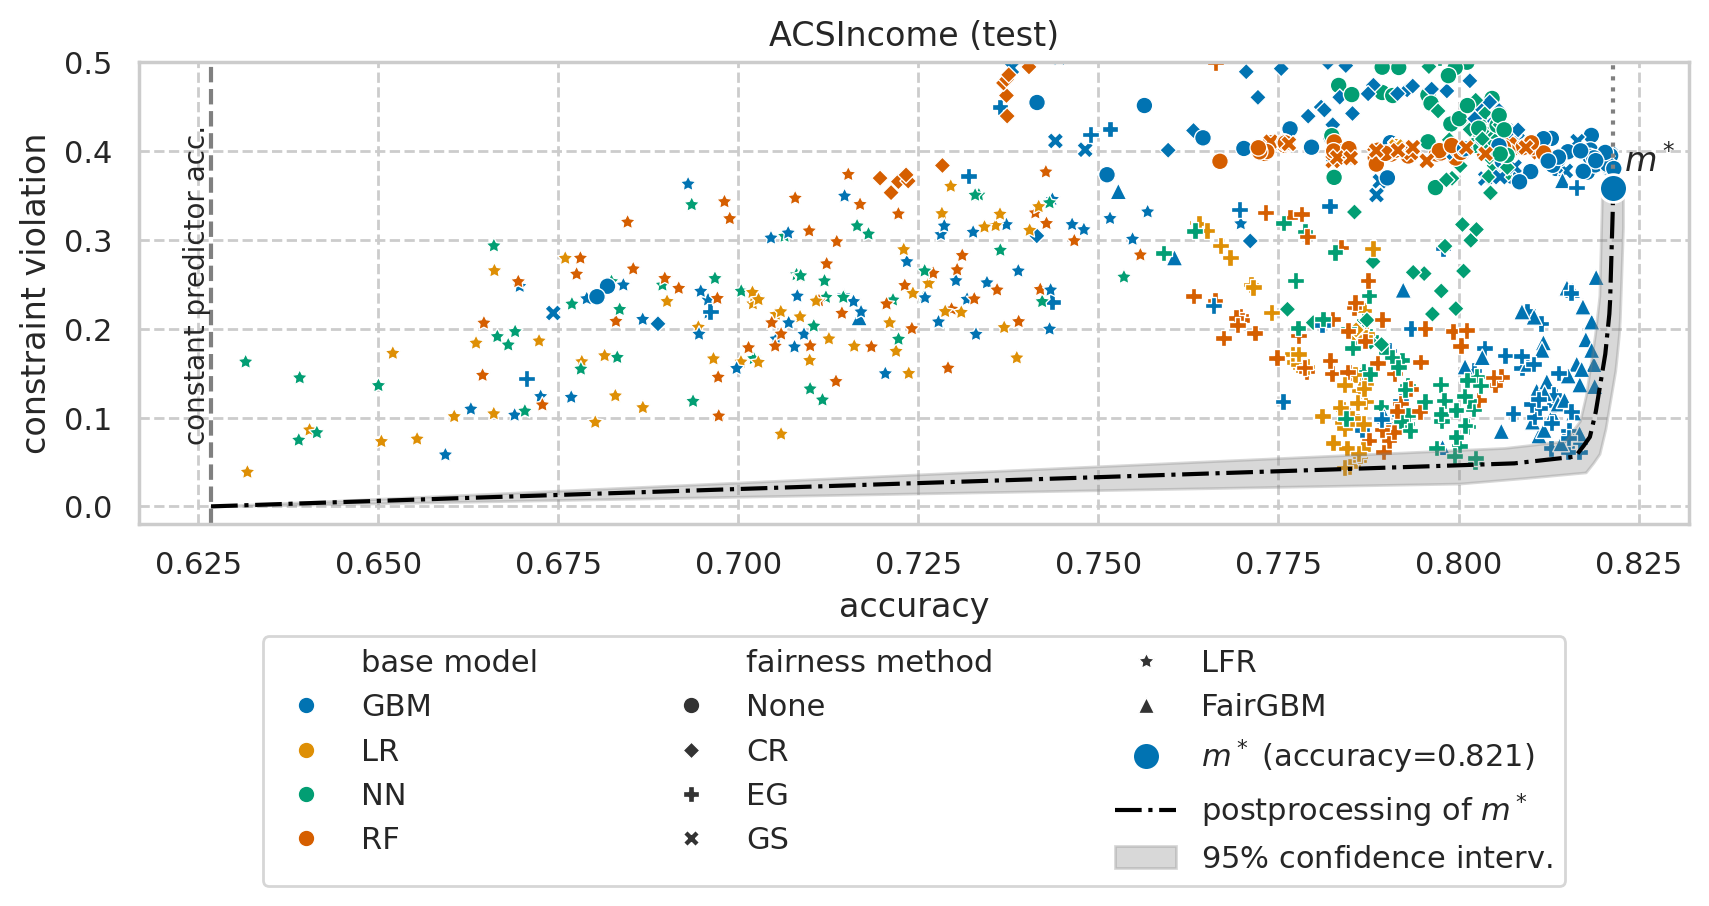

In [37]:
plot_df = get_results("original", SHOW_DATA_TYPE)
plot_df = plot_df[plot_df[PERFORMANCE_METRIC] >= task_const_pred_acc + 1e-3]    # discard worse-than-dummy predictors

# Plot all points
sns.scatterplot(
    data=plot_df,
    **scatterplot_kwargs,
)

# Plot best model (used for adjustment curve)
# best_model_acc = model_row[f"unadjusted_{SHOW_DATA_TYPE}_{PERFORMANCE_METRIC}"]
# best_model_disp = model_row[f"unadjusted_{SHOW_DATA_TYPE}_{DISPARITY_METRIC}"]

best_model_acc, best_model_disp = adjustment_frontier[-1]
plt.plot(
    best_model_acc, best_model_disp,
    color=base_model_to_color_map[model_row.base_model],
    marker=intervention_to_marker_map[model_row.intervention],
    ms=10, lw=0,
    markeredgecolor="white",
    label=f"$m^*$ (accuracy={best_model_acc:.3f})",
    zorder=10,
)

# Annotate best model with "m^*"
plt.gca().annotate(
    r"$m^*$",
    xy=(best_model_acc, best_model_disp),
    xytext=m_star_xytext,
    zorder=10,
)

# Plot adjustment curve
sns.lineplot(
    x=adjustment_frontier[:, 0],
    y=adjustment_frontier[:, 1],
    label=r"postprocessing of $m^*$",
    linestyle="-.",
    color="black",
)


#### #### #### SHADED AREA - CONFIDENCE INTERVALS
ax = plt.gca()

ax.fill_between(
    x=adjustment_frontier_xticks,
    y1=interior_frontier_yticks,
    y2=outer_frontier_yticks,
    interpolate=True,
    color="grey",
    alpha=0.3,
    label=r"$95\%$ confidence interv.",
)

#### #### #### SHADED AREA - CONFIDENCE INTERVALS


# Draw upper right portion of the line (dominated but not feasible)
upper_right_frontier = np.array([
    adjustment_frontier[-1],
    (adjustment_frontier[-1, 0] - 1e-6, 1.0),
])

sns.lineplot(
    x=upper_right_frontier[:, 0],
    y=upper_right_frontier[:, 1],
    linestyle=":",
#     label=r"dominated by $m^*$",
    color="grey",
)

# Vertical line with minimum "useful" accuracy on this data
plt.axvline(
    x=task_const_pred_acc,
    ls="--",
#     label="constant predictor",
    color="grey",
)
plt.gca().annotate(
    "constant predictor acc.",
    xy=(task_const_pred_acc, ax_kwargs["ylim"][1] / 2),
    zorder=10,
    rotation=90,
    horizontalalignment="right",
    verticalalignment="center",
    fontsize="small",
)

# plt.legend(**legend_kwargs)
plt.legend(**bottom_legend_kwargs)

plt.gca().set(**ax_kwargs)

save_fig(fig=plt.gcf(), fig_name="all-models.with-adjustment-curve")
plt.show()

---
#### 1st page version of this plot (with much less information)

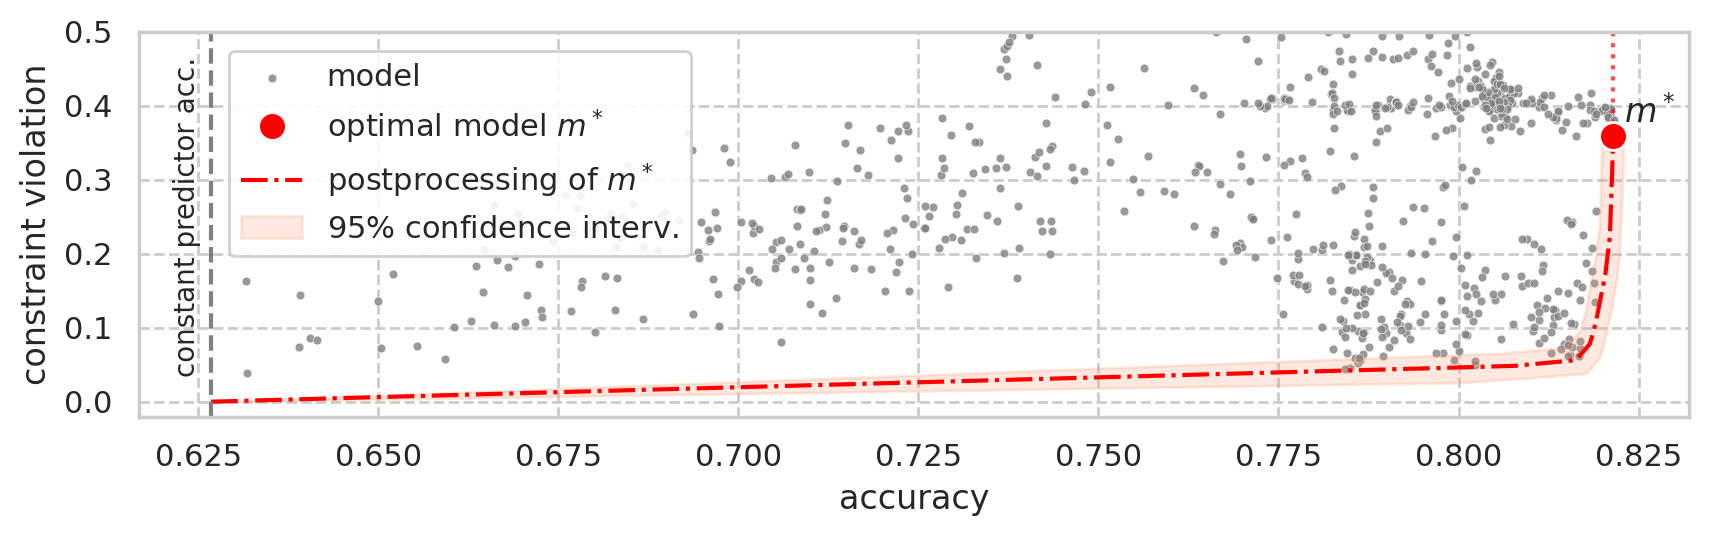

In [38]:
# First page plot
plot_df = get_results("original", SHOW_DATA_TYPE)
plot_df = plot_df[plot_df[PERFORMANCE_METRIC] >= task_const_pred_acc + 1e-3]    # discard worse-than-dummy predictors

# Plot all points
sns.scatterplot(
    data=plot_df,
    x=PERFORMANCE_METRIC,
    y=DISPARITY_METRIC,
#     color=base_model_to_color_map["NN"],
    color="grey",
    label="model",
    alpha=0.8,
    s=10,
)

# Plot best model (used for adjustment curve)
# best_model_acc = model_row[f"unadjusted_{SHOW_DATA_TYPE}_{PERFORMANCE_METRIC}"]
# best_model_disp = model_row[f"unadjusted_{SHOW_DATA_TYPE}_{DISPARITY_METRIC}"]

best_model_acc, best_model_disp = adjustment_frontier[-1]
plt.plot(
    best_model_acc, best_model_disp,
    color="red",
    marker=intervention_to_marker_map[model_row.intervention],
    ms=10, lw=0,
    markeredgecolor="white",
    label=f"optimal model $m^*$",
    zorder=10,
)

# Annotate best model with "m^*"
plt.gca().annotate(
    r"$m^*$",
    xy=(best_model_acc, best_model_disp),
    xytext=m_star_xytext,
    zorder=10,
)

# Plot adjustment curve
sns.lineplot(
    x=adjustment_frontier[:, 0],
    y=adjustment_frontier[:, 1],
    label=r"postprocessing of $m^*$",
    linestyle="-.",
    color="red",
)


#### #### #### SHADED AREA - CONFIDENCE INTERVALS
ax = plt.gca()

ax.fill_between(
    x=adjustment_frontier_xticks,
    y1=interior_frontier_yticks,
    y2=outer_frontier_yticks,
    interpolate=True,
#     color="orange",
    color=sns.color_palette("Set2")[1],
    alpha=0.2,
    label=r"$95\%$ confidence interv.",
)

#### #### #### SHADED AREA - CONFIDENCE INTERVALS


# Draw upper right portion of the line (dominated but not feasible)
upper_right_frontier = np.array([
    adjustment_frontier[-1],
    (adjustment_frontier[-1, 0] - 1e-6, 1.0),
])

sns.lineplot(
    x=upper_right_frontier[:, 0],
    y=upper_right_frontier[:, 1],
    linestyle=":",
#     label=r"dominated by $m^*$",
#     color="grey",
    color="red", alpha=0.7,
)

# Vertical line with minimum "useful" accuracy on this data
plt.axvline(
    x=task_const_pred_acc,
    ls="--",
#     label="constant predictor",
    color="grey",
)
plt.gca().annotate(
    "constant predictor acc.",
    xy=(task_const_pred_acc-(1.4e-3 if DATASET == "ACSIncome" else 0), ax_kwargs["ylim"][1] / 2),
    zorder=10,
    rotation=90,
    horizontalalignment="right",
    verticalalignment="center",
    fontsize="small",
)

# plt.legend(**legend_kwargs)
# plt.legend(**bottom_legend_kwargs)
plt.legend(
    loc="upper left",
    framealpha=0.9,
    bbox_to_anchor=(.058, 0.95),
    borderaxespad=0)

curr_ax_kwargs = ax_kwargs.copy()
curr_ax_kwargs.pop("title")

plt.gca().set(**curr_ax_kwargs)

save_fig(fig=plt.gcf(), fig_name="all-models.with-adjustment-curve.monochromatic")

# Save version with shorter height (can be useful for 1st page)
plt.gcf().set_size_inches(10, 2.5)
save_fig(fig=plt.gcf(), fig_name="all-models.with-adjustment-curve.monochromatic.shorter")

plt.show()

#### Zoomed-in version

---
#### 1. Get models in bottom right corner

In [39]:
# zoomed in axes range
zoomed_axes_range = {

    # ACS datasets w/ 3 groups
    "MEPS": dict(
        xlim=(0.84, 0.8655),
        ylim=(0.0, 0.12),
    ),
    
    # ACS datasets w/ 4 groups
    "ACSIncome": dict(
        xlim=(0.8, 0.8235),
        ylim=(0.0, 0.5),
    ),

    "ACSEmployment": dict(
        xlim=(0.8225, 0.8331),
        ylim=(0.0, 0.105),
    ),

    "ACSMobility": dict(
#         xlim=(0.762, 0.769),
        xlim=(0.758, 0.7724),
        ylim=(0.0, 0.2),
    ),

    "ACSPublicCoverage": dict(
        xlim=(0.79, 0.81),
        ylim=(0.0, 0.4),
    ),

    "ACSTravelTime": dict(
        xlim=(0.66, 0.72),
        ylim=(0.0, 0.2),
    ),
    
    # ACS datasets w/ 2 groups
    "ACSIncome_2-groups": dict(
        xlim=(0.8, 0.82),
        ylim=(0.0, 0.25),
    ),

    "ACSEmployment_2-groups": dict(
        xlim=(0.825, 0.834),
        ylim=(0.0, 0.03),
    ),

    "ACSMobility_2-groups": dict(
        xlim=(0.75, 0.771),
        ylim=(0.0, 0.06),
    ),

    "ACSPublicCoverage_2-groups": dict(
        xlim=(0.79, 0.813),
        ylim=(0.0, 0.16),
    ),

    "ACSTravelTime_2-groups": dict(
        xlim=(0.66, 0.72),
        ylim=(0.0, 0.1),
    ),
}

dataset_zoomed_axes_range = zoomed_axes_range.get(DATASET_ID, zoomed_axes_range[DATASET])
dataset_zoomed_axes_range

{'xlim': (0.8, 0.8235), 'ylim': (0.0, 0.5)}

In [40]:
curr_results_df = get_results("original", SHOW_DATA_TYPE)

zoomed_filter = (
    (curr_results_df[PERFORMANCE_METRIC] >= dataset_zoomed_axes_range["xlim"][0]) &
    (curr_results_df[DISPARITY_METRIC] >= dataset_zoomed_axes_range["ylim"][0])
)

zoomed_results_df = curr_results_df[zoomed_filter]
print(f"Number of models in zoomed-in plot: {len(zoomed_results_df)} ({len(zoomed_results_df) / len(curr_results_df):.1%})")

Number of models in zoomed-in plot: 228 (22.8%)


---

In [41]:
zoomed_ax_kwargs = ax_kwargs | dataset_zoomed_axes_range

zoomed_plot_kwargs = scatterplot_kwargs.copy()

# Remove from legend interventions and base models that are not present
base_models = zoomed_results_df["base model"].unique()
interventions = zoomed_results_df["fairness method"].unique()
zoomed_plot_kwargs["hue_order"] = [h for h in zoomed_plot_kwargs["hue_order"] if h in base_models]
zoomed_plot_kwargs["style_order"] = [m for m in zoomed_plot_kwargs["style_order"] if m in interventions]
zoomed_plot_kwargs["palette"] = [base_model_to_color_map[bm] for bm in zoomed_plot_kwargs["hue_order"]]
zoomed_plot_kwargs["markers"] = [intervention_to_marker_map[interv] for interv in zoomed_plot_kwargs["style_order"]]

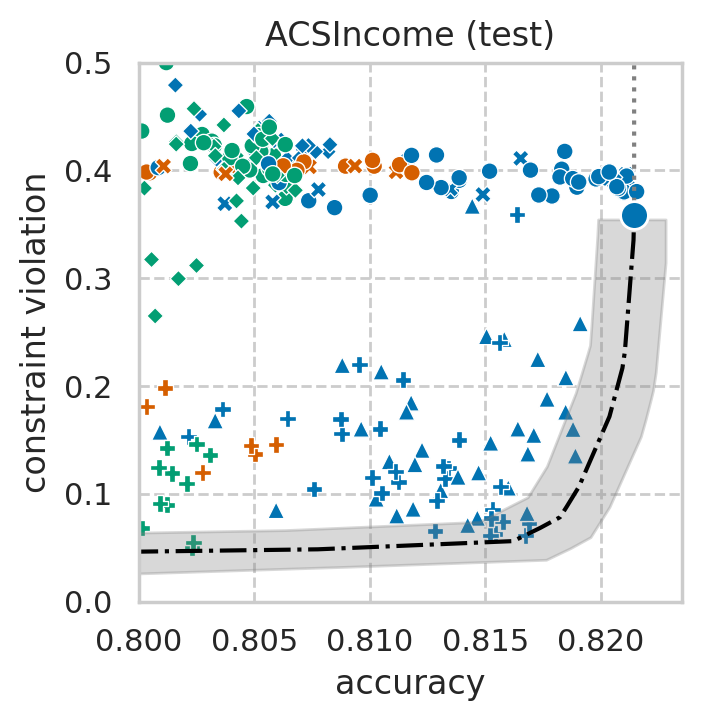

In [42]:
f = plt.figure(figsize=(3.5, 3.5))

# Plot all points
sns.scatterplot(
    data=zoomed_results_df,
    **zoomed_plot_kwargs,
)

# Plot best model (used for adjustment curve)
# best_model_results = results_df.loc[model_row.name]

show_best_model_type = "unadjusted"
# show_best_model_type = "original"
# best_model_acc = model_row[f"{show_best_model_type}_{SHOW_DATA_TYPE}_{PERFORMANCE_METRIC}"]
# best_model_disp = model_row[f"{show_best_model_type}_{SHOW_DATA_TYPE}_{DISPARITY_METRIC}"]
best_model_acc, best_model_disp = adjustment_frontier[-1]

plt.plot(
    best_model_acc, best_model_disp,
    color=base_model_to_color_map[model_row.base_model],
    marker=intervention_to_marker_map[model_row.intervention],
    ms=10, lw=0,
    markeredgecolor="white",
    label=f"$m^*$ (selected on val.)",
#     label=f"$m^*$ (accuracy={best_model_acc:.3f})",
    zorder=10,
)

# Annotate best model with "m^*"
# plt.gca().annotate(
#     r"$m^*$",
#     xy=(best_model_acc, best_model_disp),
#     xytext=(best_model_acc+3e-4, best_model_disp+1.2e-2),
#     zorder=10,
#     fontsize=8,
# )

# # Plot adjustment curve
sns.lineplot(
    x=adjustment_frontier[:, 0],
    y=adjustment_frontier[:, 1],
    label=r"postprocessing of $m^*$",
    linestyle="-.",
    color="black",
)

#### #### #### SHADED AREA - CONFIDENCE INTERVALS
ax = plt.gca()

ax.fill_between(
    x=adjustment_frontier_xticks,
    y1=interior_frontier_yticks,
    y2=outer_frontier_yticks,
    interpolate=True,
    color="grey",
    alpha=0.3,
    label=r"$95\%$ confidence interv.",
)

#### #### #### SHADED AREA - CONFIDENCE INTERVALS


# Draw upper right portion of the line (dominated but not feasible)
upper_right_frontier = np.array([
    adjustment_frontier[-1],
    (adjustment_frontier[-1, 0] - 1e-6, 1.0),
])

sns.lineplot(
    x=upper_right_frontier[:, 0],
    y=upper_right_frontier[:, 1],
    linestyle=":",
#     label=r"dominated by $m^*$",
    color="grey",
)


lg = plt.legend(**legend_kwargs)
plt.gca().set(**zoomed_ax_kwargs)

if zoomed_ax_kwargs["ylim"] == (0, 0.2):
    plt.yticks(ticks=[0, 0.05, 0.1, 0.15, 0.2], labels=["0.00", "0.05", "0.10", "0.15", "0.20"])

save_fig(fig=plt.gcf(), fig_name="zoomed-in.all-models.with-adjustment-curve")
lg.remove()
save_fig(fig=plt.gcf(), fig_name="zoomed-in.all-models.with-adjustment-curve.without-legend")

plt.show()

---
# Pareto frontiers of all models/interventions

In [43]:
from scipy.spatial import ConvexHull
from utils.notebook import is_pareto_efficient

def construct_pareto_frontier_hull(expID: str, model_type: str = "original", select_on: str = "validation"):
    
    # Get data for this `expID`
    expID_df = task_df[task_df["expID"] == expID]
    perf_col = f"{model_type}_{select_on}_{PERFORMANCE_METRIC}_mean"
    disp_col = f"{model_type}_{select_on}_{DISPARITY_METRIC}_mean"
    
    # Get Pareto efficient points
    perf_vals = expID_df[perf_col].to_numpy()
    disp_vals = expID_df[disp_col].to_numpy()
    costs = np.hstack((np.expand_dims(1-perf_vals, axis=1), np.expand_dims(disp_vals, axis=1)))

    is_pareto = is_pareto_efficient(costs)

    # Then compute convex hull of those points (if there are 3 or more points)
    pareto_df = expID_df[is_pareto]

    # Points that extend the Pareto frontier (trivial or dominated points)
    bottom_left_point = (task_const_pred_acc, np.min(pareto_df[disp_col]) - 1e-7)
    top_right_point = (np.max(pareto_df[perf_col]) + 1e-7, 1)

    if len(pareto_df) > 2:
        costs = np.stack(
            (
                1-pareto_df[perf_col],
                pareto_df[disp_col],
            ),
            axis=1)
        
        costs = np.vstack((
            (1-bottom_left_point[0], bottom_left_point[1]),
            costs,
            (1-top_right_point[0], top_right_point[1]),
        ))

        hull = ConvexHull(costs)
        hull_vertices = [v-1 for v in hull.vertices if (0 < v < len(costs)-1)]
        pareto_df = pareto_df.iloc[hull_vertices]

    # Construct np.ndarray with Pareto frontier data
    pareto_frontier = pareto_df[[perf_col, disp_col]].to_numpy()

    # Sort by performance value
    idx_sort = np.argsort(pareto_frontier[:, 0])
    pareto_frontier = pareto_frontier[idx_sort]
    
    # Add bottom left and top right points to Pareto frontier
    pareto_frontier = np.vstack((
        bottom_left_point,
        pareto_frontier,
        top_right_point,
    ))

    return pareto_frontier

In [44]:
expID_to_pareto_frontier = {
    expID: construct_pareto_frontier_hull(expID=expID, model_type="original", select_on=SHOW_DATA_TYPE)
    for expID in plot_df["expID"].unique()
}

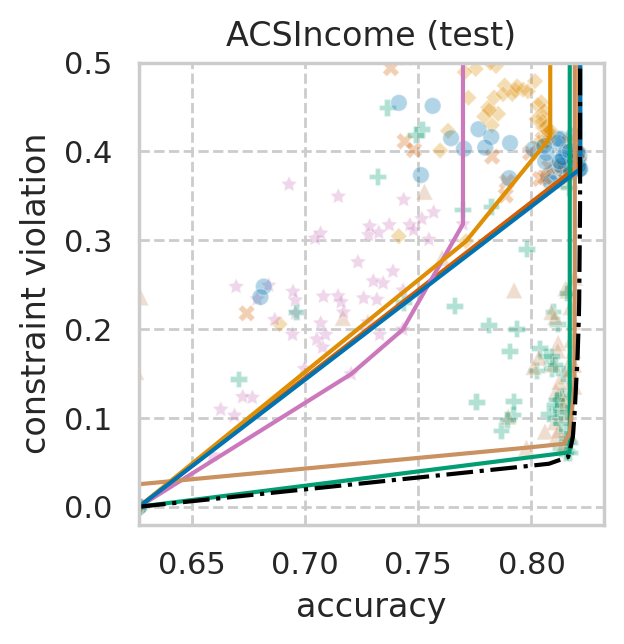

In [45]:
# Plot adjustment curve
f = plt.figure(figsize=(3, 3))

plot_df = get_results("original", SHOW_DATA_TYPE)

# TODO: make linestyles and color mappings for each expID
# TODO: maybe show only GBM expIDs

base_model = "GBM"

sns.scatterplot(
    data=plot_df[plot_df["base model"] == base_model],
    **gbm_plot_kwargs,
    alpha=0.3,
)

for expID, expID_frontier in expID_to_pareto_frontier.items():
    if base_model not in expID: continue

    sns.lineplot(
        x=expID_frontier[:, 0],
        y=expID_frontier[:, 1],
#         label=expID,
        color=gbm_exp_id_to_color_map[expID],
    )

# Postprocessing
postproc_pareto_frontier = np.vstack((
    adjustment_frontier,
    (adjustment_frontier[-1,0] + 1e-7, 1.0),
))

sns.lineplot(
    x=postproc_pareto_frontier[:, 0],
    y=postproc_pareto_frontier[:, 1],
    label=r"postprocessing",
#     label=r"postprocessing of $m^*$",
    linestyle="-.",
    color="black",
)

lg = plt.legend(**legend_kwargs)

plt.gca().set(**(ax_kwargs | dict(xlim=(task_const_pred_acc, ax_kwargs["xlim"][1]))))
plt.title(f"{DATASET} ({SHOW_DATA_TYPE})")

save_fig(fig=plt.gcf(), fig_name=f"{base_model}-pareto-frontiers", data_type=SHOW_DATA_TYPE)
lg.remove()
save_fig(fig=plt.gcf(), fig_name=f"{base_model}-pareto-frontiers.without-legend", data_type=SHOW_DATA_TYPE)

plt.show()

---